In [38]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, TensorBoard
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import seaborn as sns
from datetime import datetime
from sklearn.metrics import mean_squared_error 

In [39]:
data = pd.read_csv('all_data_results_cleaned.csv')

In [40]:
to_drop=["pipe_dn","pipe_schedule","flange_class",
        "hot_spot_stress", "max_deformation", "support_right", "support_left", "ratio"]
to_keep=["outside_diameter", "wall_thickness", "raised_face_depth",
        "w_neck_c", "flange_outer_radius", "flange_thickness_d","raised_face_radius",
        "length1", "length2", "lumped_mass", "frequency", "x_deformation_position",
        "y_deformation_position", "z_deformation_position", "support", "allowable_deformation"]

data.drop(columns=to_drop,inplace=True)

In [41]:
numeric_features = ["outside_diameter", "wall_thickness", "raised_face_depth" ,'length1', 'length2', 'lumped_mass',
                    "w_neck_c", "flange_outer_radius", "flange_thickness_d","raised_face_radius"]
categorical_features = ['support']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop=None), categorical_features)
    ])

In [42]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

In [43]:
output_columns = ['allowable_deformation', 'frequency', 'x_deformation_position', 'y_deformation_position', 'z_deformation_position']
x = data.drop(output_columns, axis=1)
y = pd.DataFrame(data[output_columns])

In [44]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=30)

In [45]:
x_train_transformed = pipeline.fit_transform(x_train)
x_test_transformed = pipeline.transform(x_test)

In [46]:
scaler_y_frequency = StandardScaler()
scaler_y_allowable_deformation = StandardScaler()

y_train_transformed_frequency = scaler_y_frequency.fit_transform(pd.DataFrame(y_train["frequency"]))
y_test_transformed_frequency = scaler_y_frequency.transform(pd.DataFrame(y_test["frequency"]))

y_train_transformed_allowable_deformation = scaler_y_allowable_deformation.fit_transform(pd.DataFrame(y_train["allowable_deformation"]))
y_test_transformed_allowable_deformation = scaler_y_allowable_deformation.transform(pd.DataFrame(y_test["allowable_deformation"]))
"""
y_train_transformed_x_displacement = scaler_y.fit_transform(pd.DataFrame(y_train["x_deformation_position"]))
y_test_transformed_x_displacement = scaler_y.transform(pd.DataFrame(y_test["x_deformation_position"]))

y_train_transformed_y_displacement = scaler_y.fit_transform(pd.DataFrame(y_train["y_deformation_position"]))
y_test_transformed_y_displacement = scaler_y.transform(pd.DataFrame(y_test["y_deformation_position"]))

y_train_transformed_z_displacement = scaler_y.fit_transform(pd.DataFrame(y_train["z_deformation_position"]))
y_test_transformed_z_displacement = scaler_y.transform(pd.DataFrame(y_test["z_deformation_position"]))
"""

'\ny_train_transformed_x_displacement = scaler_y.fit_transform(pd.DataFrame(y_train["x_deformation_position"]))\ny_test_transformed_x_displacement = scaler_y.transform(pd.DataFrame(y_test["x_deformation_position"]))\n\ny_train_transformed_y_displacement = scaler_y.fit_transform(pd.DataFrame(y_train["y_deformation_position"]))\ny_test_transformed_y_displacement = scaler_y.transform(pd.DataFrame(y_test["y_deformation_position"]))\n\ny_train_transformed_z_displacement = scaler_y.fit_transform(pd.DataFrame(y_train["z_deformation_position"]))\ny_test_transformed_z_displacement = scaler_y.transform(pd.DataFrame(y_test["z_deformation_position"]))\n'

In [47]:
logdir = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir)

In [48]:
input_layer = Input(shape=(x_train_transformed.shape[1],))
hidden1 = Dense(512, activation='relu')(input_layer)
dropout1 = Dropout(0.2)(hidden1)
hidden2 = Dense(128, activation='relu')(dropout1)


# Separate output for each target variable
output_layer = Dense(1)(hidden2)
#, name='allowable_deformation'


In [49]:
model = Model(inputs=input_layer, outputs=output_layer)

In [50]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │         7,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,473 (287.00 KB)

 Trainable params: 73,473 (287.00 KB)

 Non-trainable params: 0 (0.00 B)

In [51]:
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='mse',
              metrics=["R2Score"])

In [52]:
history = model.fit(
    x_train_transformed, 
    y_train_transformed_frequency,  # Split the targets into separate arrays
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    verbose=1,
    callbacks=[tensorboard_callback]
)

Epoch 1/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - R2Score: 0.6372 - loss: 0.3661 - val_R2Score: 0.8964 - val_loss: 0.0997
Epoch 2/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - R2Score: 0.8934 - loss: 0.1111 - val_R2Score: 0.9100 - val_loss: 0.0866
Epoch 3/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - R2Score: 0.9170 - loss: 0.0870 - val_R2Score: 0.9281 - val_loss: 0.0692
Epoch 4/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - R2Score: 0.9285 - loss: 0.0751 - val_R2Score: 0.9404 - val_loss: 0.0574
Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - R2Score: 0.9423 - loss: 0.0599 - val_R2Score: 0.9490 - val_loss: 0.0491
Epoch 6/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - R2Score: 0.9480 - loss: 0.0501 - val_R2Score: 0.9481 - val_loss: 0.0500
Epoch 7/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - R2Score: 0.9423 - loss: 0.0558 - val_R2Score: 0.9605 - val_loss: 0.0381
Epoch 8/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - R2Score: 0.9424 - loss: 0.0580 - val_R2Score: 0.9525

In [53]:
test_loss, test_mse = model.evaluate(x_test_transformed, y_test_transformed_frequency)
print('Test accuracy:', test_mse)

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - R2Score: 0.9892 - loss: 0.0117
Test accuracy: 0.9883154630661011


In [54]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │         7,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 220,421 (861.02 KB)

 Trainable params: 73,473 (287.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 146,948 (574.02 KB)

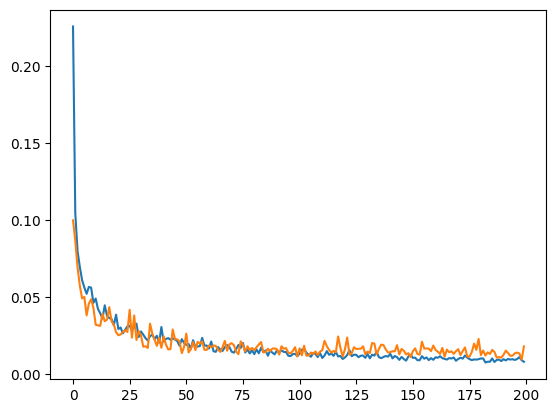

In [55]:
plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["val_loss"],label="val_loss")

In [56]:
predictions_scaled = model.predict(x_test_transformed)
predictions = scaler_y_frequency.inverse_transform((predictions_scaled))

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [57]:
predictions_df = pd.DataFrame(predictions)
print("\nSample Predictions:")
print(predictions_df.head())


Sample Predictions:
           0
0  19.605223
1   3.698713
2   8.949180
3   3.179649
4   4.218329


In [58]:
y_test["frequency"]

524      20.6428
10325     3.6637
11646     9.2175
10238     3.2967
10214     4.2590
          ...   
11507    20.6383
2709     30.6522
12218    17.6490
2858     21.5420
9935      3.6527
Name: frequency, Length: 2457, dtype: float64

In [59]:
true= y_test["frequency"].tolist()
pred= predictions_df[0].tolist()
mean_squared_error(true,pred)

4.316984072228202

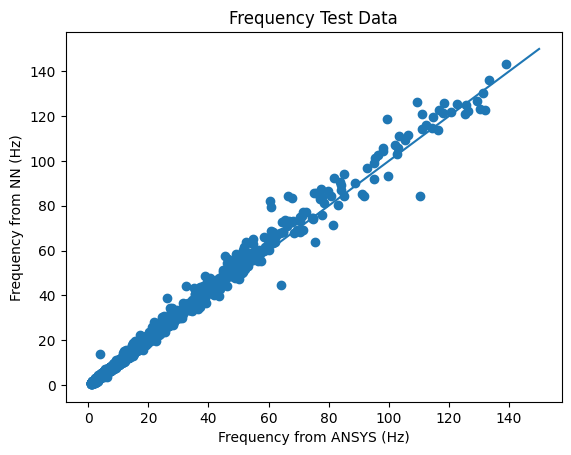

In [60]:
pred=predictions_df
true=y_test["frequency"]
plt.scatter(true,pred)
plt.plot([0, 150],[0, 150])
plt.xlabel("Frequency from ANSYS (Hz)")
plt.ylabel("Frequency from NN (Hz)")
plt.title("Frequency Test Data")
plt.show()

In [61]:
input_layer = Input(shape=(x_train_transformed.shape[1],))
hidden1 = Dense(1024, activation='relu')(input_layer)
dropout1 = Dropout(0.2)(hidden1)
hidden2 = Dense(64, activation='relu')(dropout1)


# Separate output for each target variable
output_layer = Dense(1)(hidden2)
#, name='allowable_deformation'

In [62]:
model_d = Model(inputs=input_layer, outputs=output_layer)

In [63]:
model_d.compile(optimizer=Adam(learning_rate=0.001), 
              loss='mse',
              metrics=["R2Score"])

In [64]:
history_d = model_d.fit(
    x_train_transformed, 
    y_train_transformed_allowable_deformation,  # Split the targets into separate arrays
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    verbose=1,
    callbacks=[tensorboard_callback]
)

Epoch 1/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - R2Score: 0.6243 - loss: 0.4095 - val_R2Score: 0.8862 - val_loss: 0.1052
Epoch 2/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - R2Score: 0.9069 - loss: 0.0915 - val_R2Score: 0.9312 - val_loss: 0.0636
Epoch 3/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - R2Score: 0.9304 - loss: 0.0645 - val_R2Score: 0.9472 - val_loss: 0.0488
Epoch 4/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - R2Score: 0.9406 - loss: 0.0630 - val_R2Score: 0.9295 - val_loss: 0.0651
Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - R2Score: 0.9498 - loss: 0.0544 - val_R2Score: 0.9558 - val_loss: 0.0408
Epoch 6/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - R2Score: 0.9497 - loss: 0.0475 - val_R2Score: 0.9193 - val_loss: 0.0746
Epoch 7/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - R2Score: 0.9444 - loss: 0.0567 - val_R2Score: 0.9554 - val_loss: 0.0412
Epoch 8/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - R2Score: 0.9514 - loss: 0.0491 - val_R2Score: 0.9459 - v

In [65]:
test_loss, test_mse = model_d.evaluate(x_test_transformed, y_test_transformed_allowable_deformation)
print('Test accuracy:', test_mse)

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - R2Score: 0.9754 - loss: 0.0282
Test accuracy: 0.9704837799072266


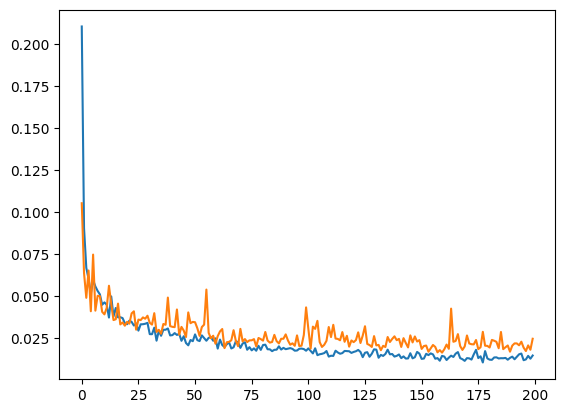

In [66]:
plt.plot(history_d.history["loss"],label="loss")
plt.plot(history_d.history["val_loss"],label="val_loss")

In [67]:
predictions_scaled_d = model_d.predict(x_test_transformed)
predictions_d = scaler_y_allowable_deformation.inverse_transform((predictions_scaled_d))

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [68]:
predictions_df_d = pd.DataFrame(predictions_d)
print("\nSample Predictions:")
print(predictions_df_d)


Sample Predictions:
              0
0     11.228002
1     11.170722
2      5.630940
3     13.451259
4     14.354552
...         ...
2452   2.746951
2453   6.667775
2454   1.838136
2455   1.663586
2456  11.700732

[2457 rows x 1 columns]


In [69]:
y_test["allowable_deformation"]

524      13.586
10325    11.513
11646     5.124
10238    13.693
10214    15.469
          ...  
11507     3.243
2709      3.497
12218     2.108
2858      1.647
9935     10.959
Name: allowable_deformation, Length: 2457, dtype: float64

In [70]:
true= y_test["allowable_deformation"].tolist()
pred_d= predictions_df_d[0].tolist()
mean_squared_error(true,pred_d)

188.7240609967003

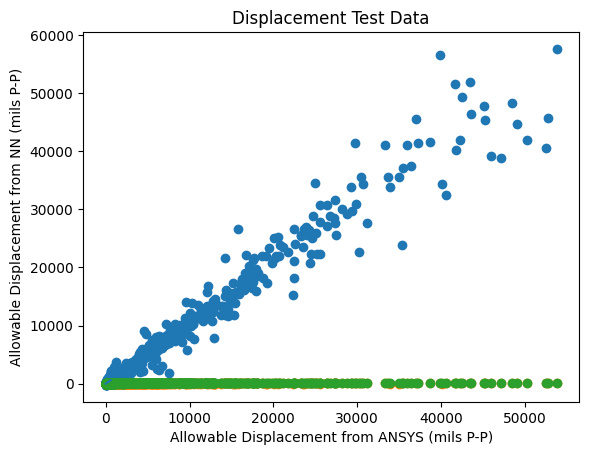

In [71]:
plot_NN_test_displacement_0P_mm=predictions_df_d
plot_NN_test_displacement_PP_mm = plot_NN_test_displacement_0P_mm*2
plot_NN_test_displacement_PP_mils = plot_NN_test_displacement_PP_mm/0.0254

plot_ANSYS_test_displacement_0P_mm = y_test["allowable_deformation"]
plot_ANSYS_test_displacement_PP_mm = plot_ANSYS_test_displacement_0P_mm*2
plot_ANSYS_test_displacement_PP_mils = plot_ANSYS_test_displacement_PP_mm/0.0254

plt.scatter(plot_ANSYS_test_displacement_PP_mils, plot_NN_test_displacement_PP_mils)
plt.plot([0, 600],[0, 600])



f=y_test["frequency"]
plot_EI_PROBLEM_velocity_RMS_mm = 10**((np.log10(f)+1.871083)/2.084547)
plot_EI_PROBLEM_velocity_PP_mm = plot_EI_PROBLEM_velocity_RMS_mm*(2**0.5)
plot_EI_PROBLEM_displacement_PP_mm = plot_EI_PROBLEM_velocity_PP_mm/(2*np.pi*f)
plot_EI_PROBLEM_displacement_PP_mils = plot_EI_PROBLEM_displacement_PP_mm/0.0254

plot_WACHEL_DANGER_dispalcement_PP_mils = (250/f)**0.5*10

plt.scatter(plot_ANSYS_test_displacement_PP_mils, plot_EI_PROBLEM_displacement_PP_mils)
plt.scatter(plot_ANSYS_test_displacement_PP_mils, plot_WACHEL_DANGER_dispalcement_PP_mils)


plt.xlabel("Allowable Displacement from ANSYS (mils P-P)")
plt.ylabel("Allowable Displacement from NN (mils P-P)")
plt.title("Displacement Test Data")

plt.show()

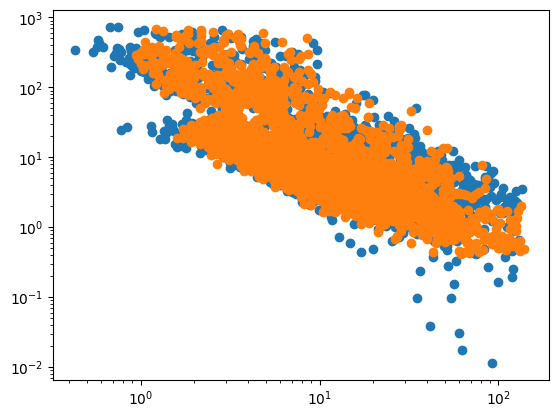

In [72]:
y=predictions_df_d
x=predictions_df
plt.scatter(x,y)
plt.loglog()
y=y_test["allowable_deformation"]
x=y_test["frequency"]
plt.scatter(x,y)
plt.show()